#  Prediction Disease OUtbreak Using Time Series Model

In [29]:
#use only cpu and not use gpu

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Import library

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.preprocessing import MinMaxScaler

In [31]:
# Load data
url = "https://raw.githubusercontent.com/datasets/covid-19/main/data/countries-aggregated.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df.head()



,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0


In [32]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161568 entries, 0 to 161567
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       161568 non-null  datetime64[ns]
 1   Country    161568 non-null  object        
 2   Confirmed  161568 non-null  int64         
 3   Recovered  161568 non-null  int64         
 4   Deaths     161568 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.2+ MB


there is no missng value

In [33]:
# feature selection

df_bd = df[df['Country'] == 'Bangladesh'].copy()
df_bd = df_bd.rename(columns={'Date': 'date', 'Confirmed': 'cases'})
df_bd = df_bd[['date', 'cases']].set_index('date')
df_bd = df_bd.asfreq('D').interpolate() 

In [34]:
df_bd.head()

,cases
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


In [35]:
df_bd.isnull().sum()

cases    0
dtype: int64

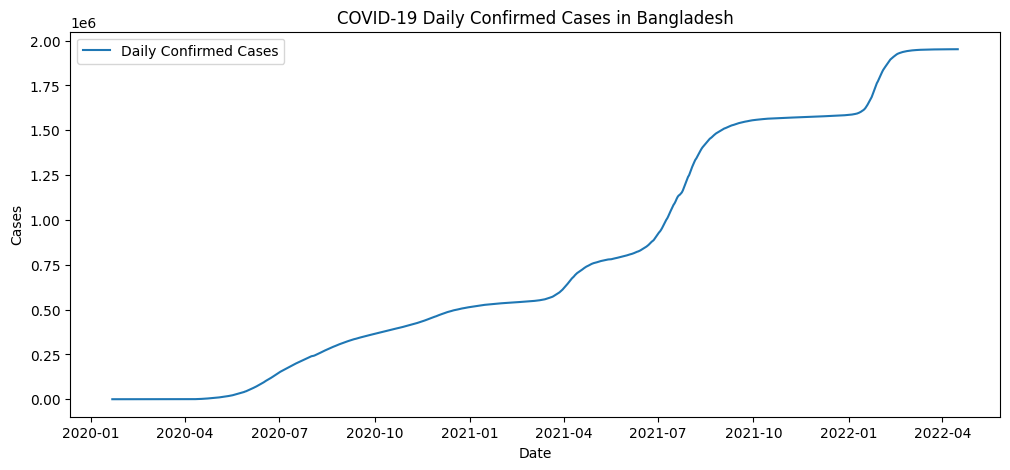

In [36]:
# Visualize raw data

plt.figure(figsize=(12,5))
plt.plot(df_bd.index, df_bd['cases'], label='Daily Confirmed Cases')
plt.title('COVID-19 Daily Confirmed Cases in Bangladesh')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

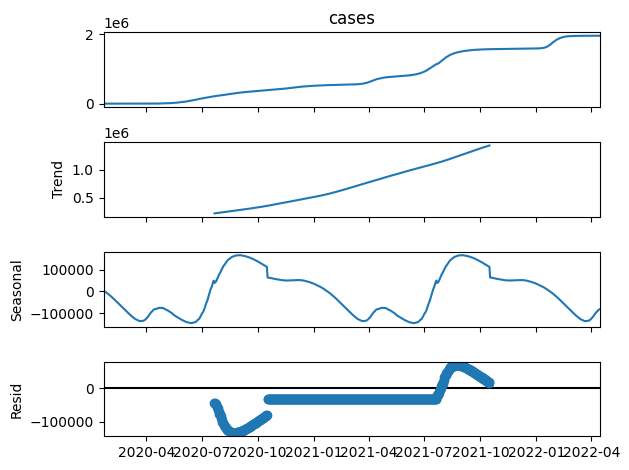

In [37]:
# Seasonal decomposition

result = seasonal_decompose(df_bd['cases'], model='additive', period=365)
result.plot()
plt.show()

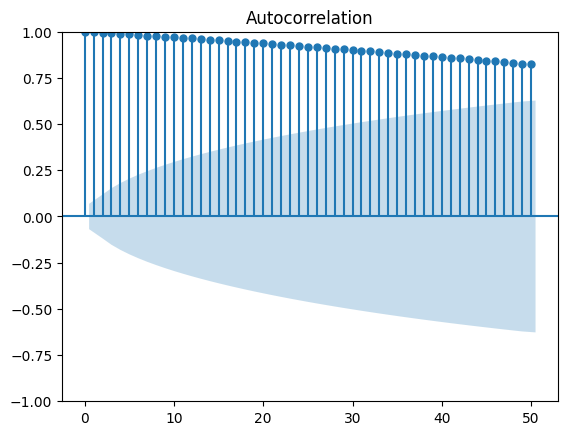

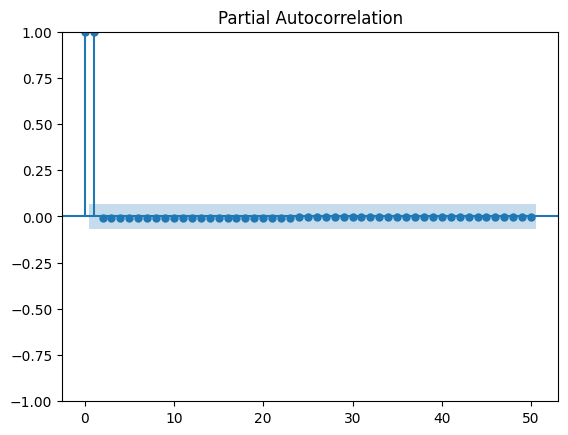

In [38]:
# ACF and PACF plots

plot_acf(df_bd['cases'], lags=50)
plot_pacf(df_bd['cases'], lags=50)
plt.show()

1 .degree of differencing:
Since ACF decays slowly,  series is likely non-stationary. use d=1

2.AR order:
From PACF, significant spikes at lags 1 and 2 so p=2.

3.MA order:
 since PACF cuts off after lag 2 and ACF decays, likely q=0 or small.

In [39]:
# Stationarity test

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_bd['cases'])
print(f'ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')

ADF Statistic: 0.0636, p-value: 0.9635


In [40]:
# For stationary

if adf_result[1] > 0.05:
    df_bd['cases_diff'] = df_bd['cases'].diff().dropna()
    adf_result_diff = adfuller(df_bd['cases_diff'].dropna())
    print(f'After differencing - ADF Statistic: {adf_result_diff[0]:.4f}, p-value: {adf_result_diff[1]:.4f}')
else:
    df_bd['cases_diff'] = df_bd['cases']

After differencing - ADF Statistic: -3.6700, p-value: 0.0046


In [41]:
# Prepare train/test split

train_size = int(len(df_bd) * 0.8)
train, test = df_bd.iloc[:train_size], df_bd.iloc[train_size:]


In [42]:
# ARIMA Model 1

arima_order = (2,1,0)  
arima_model = ARIMA(train["cases"], order=arima_order)
arima_model_fit_1 = arima_model.fit()
arima_forecast_1 = arima_model_fit_1.forecast(steps=len(test))

In [43]:
# model sumarry

arima_model_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  652
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5186.445
Date:                Tue, 12 Aug 2025   AIC                          10378.889
Time:                        16:11:57   BIC                          10392.325
Sample:                    01-22-2020   HQIC                         10384.100
                         - 11-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9781      0.012     78.367      0.000       0.954       1.003
ar.L2          0.0050      0.011      0.438      0.662      -0.017       0.027
sigma2      4.877e+05   8124.582     60.022      0.000    4.72e+05    5.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11449.28
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              17.51   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# ARIMA Model 2

arima_order = (2,1,1)  # example order; tune as needed
arima_model = ARIMA(train["cases"], order=arima_order)
arima_model_fit_2= arima_model.fit()
arima_forecast_2= arima_model_fit_2.forecast(steps=len(test))

/home/kibria/dl_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kibria/dl_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [45]:
# model summary
arima_model_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  652
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -5183.475
Date:                Tue, 12 Aug 2025   AIC                          10374.949
Time:                        16:11:57   BIC                          10392.863
Sample:                    01-22-2020   HQIC                         10381.897
                         - 11-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1508      0.038      3.973      0.000       0.076       0.225
ar.L2          0.8163      0.037     22.154      0.000       0.744       0.889
ma.L1          0.8845      0.031     28.243      0.000       0.823       0.946
sigma2      4.832e+05   8012.995     60.307      0.000    4.68e+05    4.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):             12466.96
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):              16.38   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Evaluation function

def evaluate(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Align true values for LSTM prediction length
true_values_arima = test['cases']


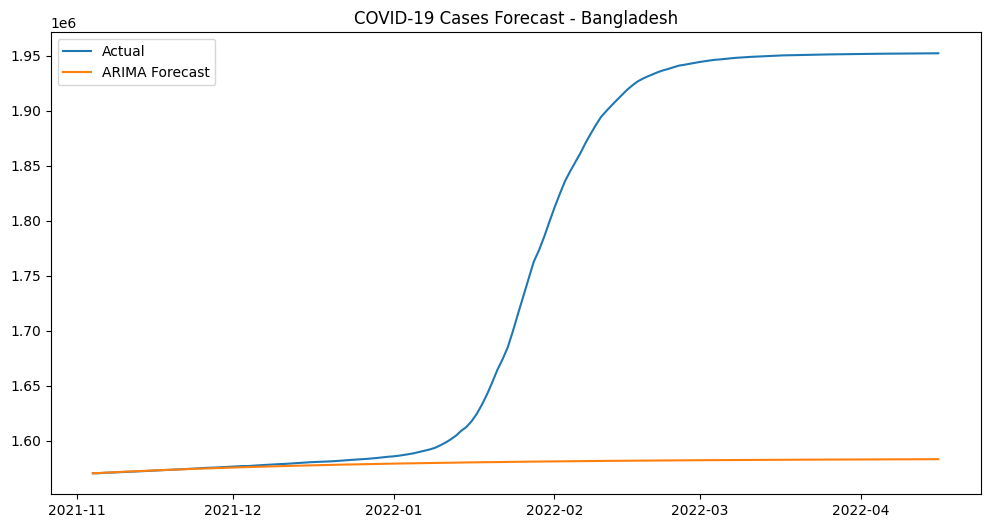

In [47]:
# graph arima model between true value and predictd value

plt.figure(figsize=(12,6))
plt.plot(test.index, test['cases'], label='Actual')
plt.plot(test.index, arima_forecast_2, label='ARIMA Forecast')
plt.legend()
plt.title('COVID-19 Cases Forecast - Bangladesh')
plt.show()


# Deep learning 
#LSTM model

In [48]:


# Load data
url = "https://raw.githubusercontent.com/datasets/covid-19/main/data/countries-aggregated.csv"
df = pd.read_csv(url, parse_dates=['Date'])



In [49]:
# feature selection

df_bd = df[df['Country'] == 'Bangladesh'].copy()
df_bd = df_bd.rename(columns={'Date': 'date', 'Confirmed': 'cases'})
df_bd = df_bd[['date', 'cases']].set_index('date')
df_bd = df_bd.asfreq('D').interpolate()  # fill missing dates & interpolate

In [50]:
# Prepare train/test split
train_size = int(len(df_bd) * 0.8)
train, test = df_bd.iloc[:train_size], df_bd.iloc[train_size:]

In [51]:
# Prepare data for LSTM
SEQ_LEN = 10  

# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

In [52]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(128, activation='relu', input_shape=(SEQ_LEN, 1)),

    Dense(1)
   

])
lstm_model.compile(optimizer='adam', loss='mse')

/home/kibria/dl_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
# Train LSTM
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)


In [54]:
# Predict with LSTM
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [55]:

# Align true values for LSTM prediction length
true_values_arima = test['cases']
true_values_lstm = test['cases'][SEQ_LEN:]

# Evaluate
evaluate(true_values_arima,arima_forecast_2, 'ARIMA')
evaluate(true_values_lstm, lstm_pred.flatten(), 'LSTM')

ARIMA - MAE: 173726.03, RMSE: 241388.53
LSTM - MAE: 28645.48, RMSE: 30049.47


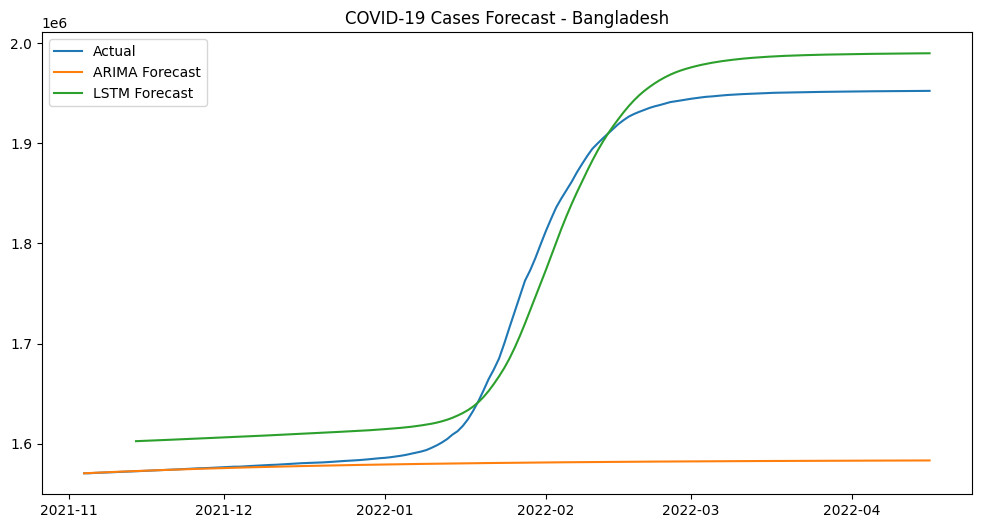

In [56]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(test.index, test['cases'], label='Actual')
plt.plot(test.index, arima_forecast_2, label='ARIMA Forecast')
plt.plot(test.index[SEQ_LEN:], lstm_pred, label='LSTM Forecast')
plt.legend()
plt.title('COVID-19 Cases Forecast - Bangladesh')
plt.show()